# Deep Dream

## Load pretrained Model

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/deepdream

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.12.0'

In [2]:
# Load pretrained image classification model
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

- `include_top=False` means we are going to take only the convolutional and pooling layer except the dense layers
- `weights='imagenet'` means this model was trained with the imagenet dataset

In [3]:
# base_model.summary()

In [4]:
len(base_model.layers)

311

In [5]:
# The first layer of InceptionV3 architecture
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [6]:
# There are concatednated layers in inceptionV3 network, called 'mixed layers'
# Maximize the activations of these mixed layers to generate deep dream image
layer_names = ['mixed4', 'mixed7']
layers_to_train = [base_model.get_layer(layer_name).output for layer_name in layer_names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers_to_train)

## Load and Preprocess the Image

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
image_path = '/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Images/tajmahal.jpg'

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(225, 375))

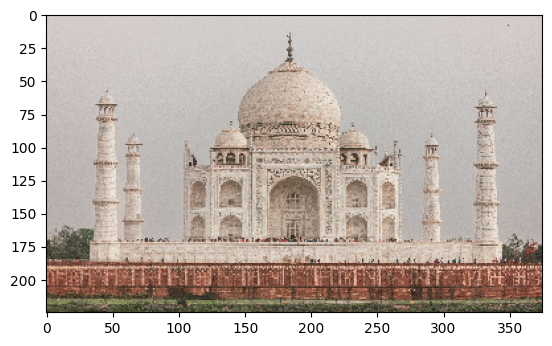

In [9]:
plt.imshow(image);

In [10]:
type(image)

PIL.Image.Image

In [11]:
image.mode, len(image.mode)

('RGB', 3)

In [12]:
# Print RGB value per pixels in image
# list(image.getdata())

In [13]:
# Convert PIL image to numpy type to work with TensorFlow
image = tf.keras.preprocessing.image.img_to_array(image)

In [14]:
type(image)

numpy.ndarray

In [15]:
# Apply the preprocessing used in the InceptionV3 model as it is
image = tf.keras.applications.inception_v3.preprocess_input(image)

## Get the Activations

In [16]:
# widht, height, number of channels
image.shape

(225, 375, 3)

- In order to be included in the deep learning model, batch size must also be added in dimensions

In [17]:
image_batch = tf.expand_dims(image, axis=0)

image_batch.shape

TensorShape([1, 225, 375, 3])

In [18]:
activations = dream_model(image_batch)

In [19]:
 len(activations)

2

In [20]:
dream_model.outputs

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed4')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed7')>]

## Calculate the Loss

In [21]:
def calculate_loss(image, network):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    image_batch = tf.expand_dims(image, axis=0)
    layer_activations = network(image_batch)

    losses = []
    for layer_activation in layer_activations:
        loss = tf.math.reduce_mean(layer_activation) # average of the activations
        losses.append(loss)

    return tf.reduce_sum(losses)

- In Deep Dream, the loss is updated by comparing the active value with the image

In [22]:
loss = calculate_loss(image, dream_model)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.2696812>

## Run Deep Dream

In [23]:
# Compare the activations with the pixels
# Emphasize parts of the image
# Change the pixels of the input image

@tf.function
def deep_dream(network, image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calculate_loss(image, network)

    gradients = tape.gradient(loss, image)  # Derivate
    gradients /= tf.math.reduce_std(gradients) + 1e-8  # Normalizing
    image = image + gradients * learning_rate  # Gradient Ascent
    image = tf.clip_by_value(image, -1, 1)  # Clip the value less than -1 and greater than 1 (Because in the beginning, it was normalized between -1 and 1)

    return loss, image

In [24]:
def inverse_transform(image):
    image = 255 * (image + 1.0) / 2.0  # Restore to visualize normalized images
    return tf.cast(image, tf.uint8)  # Cast the pixel to int type

In [25]:
def run_deep_dream(network, image, epochs, learning_rate):
    for epoch in range(epochs):
        loss, image = deep_dream(network, image, learning_rate)

        if epoch % 5000 == 0:
            plt.figure(figsize=(8,8))
            plt.imshow(inverse_transform(image))
            plt.show()
            print(f'Epoch {epoch}, loss {loss}')

In [26]:
run_deep_dream(network=dream_model, image=image, epochs=60001, learning_rate=0.0001)

Output hidden; open in https://colab.research.google.com to view.